In [1]:
import torch
from torchvision import models, transforms
from torch.autograd import Variable
from PIL import Image
import numpy as np
from stkm.TKM import TKM
import matplotlib.pyplot as plt
from cv_stkm import (get_image, generate_input_data, return_masked_image, 
                     compare_true_vs_predicted_bboxes, return_bbox_image,
                    return_masked_annotation, train_json_to_df, evaluate_bbox_prediction, 
                    return_true_and_predicted_bbox_image)
import time

/opt/anaconda3/envs/tkm/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/tkm/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
# Load a pre-trained ResNet model
model = models.resnet50(pretrained=True)
layers = list(model.children())[:-2]

model = torch.nn.Sequential(*(layers))  # Keep the spatial dimensions in the output
model.eval()

# Image transformation pipeline
preprocess = transforms.Compose([
    transforms.Resize((224,224)),  # Change this to the size of your images if you want to maintain the same resolution
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# If you want to compare to ground truth bboxes

In [2]:
# Need to have a train.json file downloaded from a youtube vis challenge

path_to_train_json = 'cv_data/vis-train/train.json'
annotation_df, video_df = train_json_to_df(json_path=path_to_train_json)


In [3]:
#number of trials of stkm to run-- we want to return the one that gets the 
#best result compared to the true bboxes

trials = 5

cv_data/train/JPEGImages/0b7dbfa3cb/ Running stkm


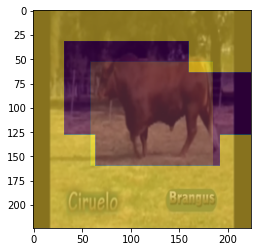

In [4]:
#Directory in which to find video frames
dir_name = 'cv_data/train/JPEGImages/0b7dbfa3cb/'

#Extract the relevant video from the dataframes 
root_filename = dir_name.split('/')[-2]
relevant_video = video_df[video_df['root_filename'] == root_filename]

#Make sure you've chosen a video for which we have ground truth available
if len(relevant_video) == 0:
    print(dir_name, ' No labels available')

else:
    relevant_annotations = annotation_df[annotation_df['video_id'] == relevant_video['id'].values[0]]
    tracked_objects = relevant_annotations['bboxes'].values
    
    #for now, if there's more than one tracked ground truth object, ignore the video
    if len(tracked_objects)>1:
        print(dir_name, 'More than one tracked object')
    
    else:
        #Load data
        image_paths, input_data = generate_input_data(dir_name)
        og_image, og_size = get_image(image_path = image_paths[0])
    
        print(dir_name, 'Running stkm')
        
        #Run a handful of trials of stkm
        max_score = 0
        tkm = TKM(input_data)
        for trial in range(trials):
            start_time = time.time()
            tkm.perform_clustering(num_clusters=2, lam=0, max_iter=1000, init_centers = 'kmeans_plus_plus')
            #Evaluate performance
            new_score, true_mask, extended_mask = evaluate_bbox_prediction(true_bboxes = tracked_objects[0],
                                                         weights = tkm.weights,
                                                         og_cols = og_size[0],
                                                         og_rows = og_size[1])
            if new_score>max_score:
                max_score = new_score
                runtime = time.time() - start_time

            
        plt.figure()
        plt.imshow(og_image.resize((224,224)))
        plt.imshow(true_mask, alpha = 0.3)
        plt.imshow(extended_mask, alpha = 0.5)
        plt.show()



    
    

If you want to visualize the evolution of the masks over time, specify the index of the frame you want to see.

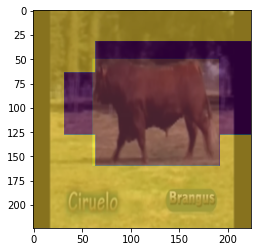

In [5]:
return_true_and_predicted_bbox_image(root_filename = root_filename,
                                     image_paths = image_paths, 
                                     index = 10, 
                                     annotation_df = annotation_df,
                                     video_df = video_df,
                                     weights = tkm.weights)

# If you just want the output of STKM with no ground truth

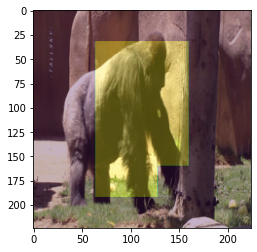

In [6]:
dir = 'cv_data/train/JPEGImages/0b34ec1d55/' #0ae1ff65a5/'
image_paths, input_data = generate_input_data(image_directory=dir)

tkm = TKM(input_data)
tkm.perform_clustering(num_clusters = 2, lam = .8, max_iter = 1000)
return_masked_image(image_paths = image_paths, index = 15, weights = tkm.weights)